In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import namedtuple
import os
from time import time
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms

import opacus
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator

from utils import generate_run_id, get_input_args, Args
from models import Discriminator_FC, Generator_MNIST, Weight_Clipper, G_weights_init
from data import load_MNIST
from metrics import get_IS, get_FID

In [ ]:
# Random Seeding
torch.manual_seed(0)
np.random.seed(0)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

activation = 'LeakyReLU'
args = Args(
    # Model Parameters
    hidden=[16, 12], nz=100, ngf=32, nc=1, activation=activation,
    # Privacy Parameters
    epsilon=50.0, delta=1e-6, noise_multiplier=0.3, c_p=0.01, 
    # Training Parameters
    lr=1e-3, beta1=0.5, batch_size=16, n_d=3, n_g=int(1e4), lambda_gp=10.0,
)

# Generate Run ID
run_id = generate_run_id(args)


run_id = "public_16-12_100_32_1_inf_1e-06_0.4_0.005_0.0001_0.5_64_4_300000_LeakyReLU"
# run_id = "16-12_100_32_1_inf_1e-06_0.4_0.005_0.0005_0.5_64_5_50000"
# /home/jason/p2/runs/16-12_100_32_1_inf_1e-06_0.4_0.005_0.0005_0.5_64_5_50000
# run_id = "16-12_100_32_1_50.0_1e-06_0.6_0.005_0.0001_0.5_64_4_300000_Tanh"
# run_id = "16-12_100_32_1_50.0_1e-06_0.6_0.005_0.0001_0.5_64_5_300000_Tanh"
run_id = "16-12_100_32_1_50.0_1e-06_0.2_0.005_0.0001_0.5_64_4_300000_Tanh"

# Create Folder Path
run_fp = os.path.join('runs/', run_id)
run_fp

In [2]:
import os

os.listdir("runs_gen_fc/")

['public_128_100_32_1_inf_1e-06_0.0_0.02_5e-05_0.0_64_3_100000_LeakyReLU_0.0',
 'public_128_100_32_1_inf_1e-06_0.0_0.0_0.0005_0.0_64_5_100000_LeakyReLU_10.0',
 'public_128_100_32_1_inf_1e-06_0.0_0.02_0.0005_0.0_64_5_100000_LeakyReLU_0.0',
 'public_128_100_32_1_inf_1e-06_0.0_0.01_0.0005_0.0_64_5_100000_LeakyReLU_0.0',
 'public_128_100_32_1_inf_1e-06_0.0_0.005_5e-05_0.0_64_3_100000_LeakyReLU_0.0',
 'public_128_100_32_1_inf_1e-06_0.0_0.02_5e-05_0.0_64_5_100000_LeakyReLU_0.0',
 'public_128_100_32_1_inf_1e-06_0.0_0.01_5e-05_0.0_64_5_100000_LeakyReLU_0.0',
 'public_128_100_32_1_inf_1e-06_0.0_0.005_5e-05_0.0_64_5_100000_LeakyReLU_0.0',
 'public_128_100_32_1_inf_1e-06_0.0_0.005_0.0005_0.0_64_3_100000_LeakyReLU_0.0',
 'public_128_100_32_1_inf_1e-06_0.0_0.02_0.0005_0.0_64_3_100000_LeakyReLU_0.0',
 'public_128_100_32_1_inf_1e-06_0.0_0.0_0.0005_0.0_64_3_100000_LeakyReLU_10.0',
 'public_128_100_32_1_inf_1e-06_0.0_0.01_5e-05_0.0_64_3_100000_LeakyReLU_0.0',
 'public_128_50_32_1_inf_1e-06_0.0_0.0_5e-0

In [ ]:
import os
# run_id = "16-12_100_32_1_50.0_1e-06_0.6_0.005_0.0001_0.5_32_4_500000"
run_fp = os.path.join('runs/', run_id)

# Read loss.txt
# 4 lines of discriminator loss, 1 line of generator loss
# Seperate discriminator loss and generator loss
loss_fp = os.path.join(run_fp, 'loss.txt')
epsilons = []
d_loss, g_loss = [], []

with open(loss_fp, 'r') as f:
    loss = f.read().splitlines()
    for i in range(len(loss)):
        if "time" in loss[i]:
            continue
        idx, l = loss[i].split(", ")

        if "." in idx:
            # Discriminator_FC Loss
            idx = int(float(idx))
            d_loss.append((idx, float(l)))
        else:
            # Generator Loss
            idx = int(float(idx))
            g_loss.append((idx, float(l)))


In [ ]:
g_loss[197: 201]

In [ ]:
# Graph Loss
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator_FC Loss During Training")
plt.plot(*zip(*d_loss), label="Discriminator_FC")
plt.plot(*zip(*g_loss), label="Generator")
plt.xlabel("iterations")
plt.ylabel("Loss")

# Only show first 100 epochs
# plt.xlim(-10, 20000)
plt.legend()
plt.show()

In [ ]:
def generate_samples(fp):
    G = Generator_MNIST(nz=args.nz, ngf=args.ngf, nc=args.nc).to(device)
    G.load_state_dict(torch.load(os.path.join(run_fp, fp)))
    G.eval()
    # Generate Sample Images
    noise = torch.randn(32, 100, 1, 1).to(device)
    fake = G(noise)
    fake = fake.view(fake.size(0), 1, 28, 28)
    print(torch.min(fake), torch.max(fake))

    # Plot Sample Images
    fig, ax = plt.subplots(4, 8, figsize=(10, 5))
    for i in range(4):
        for j in range(8):
            ax[i, j].imshow(fake[i*8+j][0].detach().cpu().numpy(), cmap='gray')
            ax[i, j].axis('off')
    plt.show()

netG_2000.pt
tensor(0.3453, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4996, device='cuda:0', grad_fn=<MaxBackward1>)


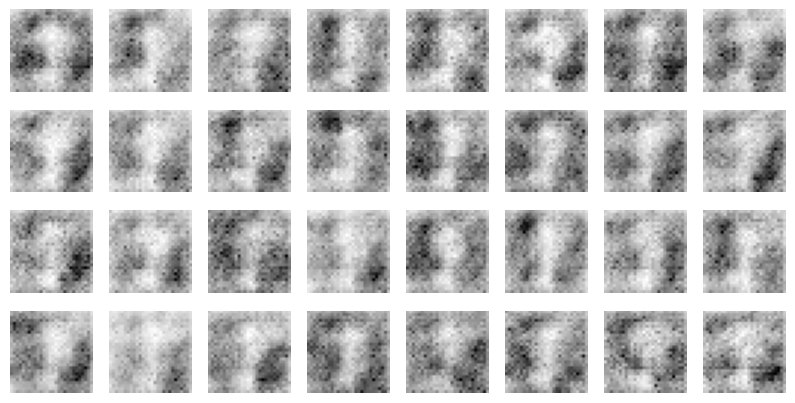

netG_4000.pt
tensor(0.5000, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5000, device='cuda:0', grad_fn=<MaxBackward1>)


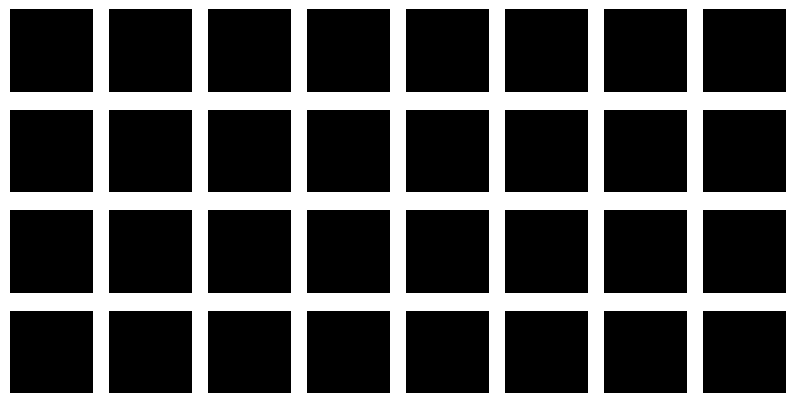

netG_6000.pt
tensor(0.5000, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5000, device='cuda:0', grad_fn=<MaxBackward1>)


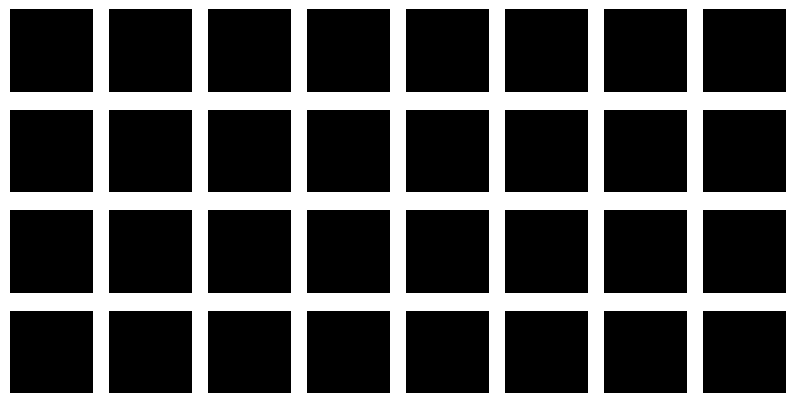

netG_8000.pt
tensor(0.5000, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5000, device='cuda:0', grad_fn=<MaxBackward1>)


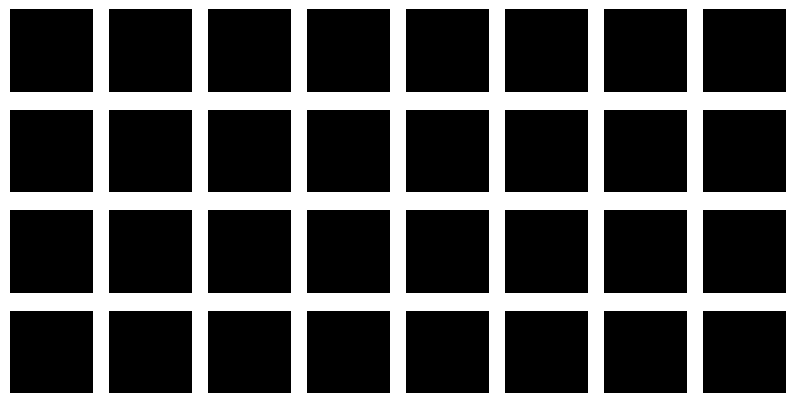

netG_10000.pt
tensor(0.5000, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5000, device='cuda:0', grad_fn=<MaxBackward1>)


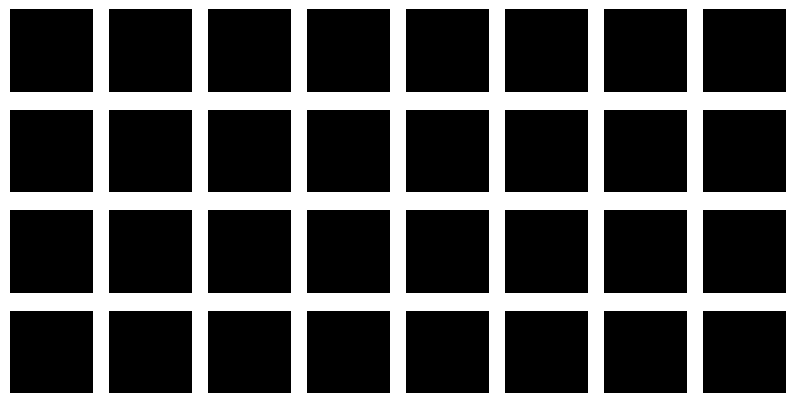

netG_12000.pt
tensor(0.5000, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5000, device='cuda:0', grad_fn=<MaxBackward1>)


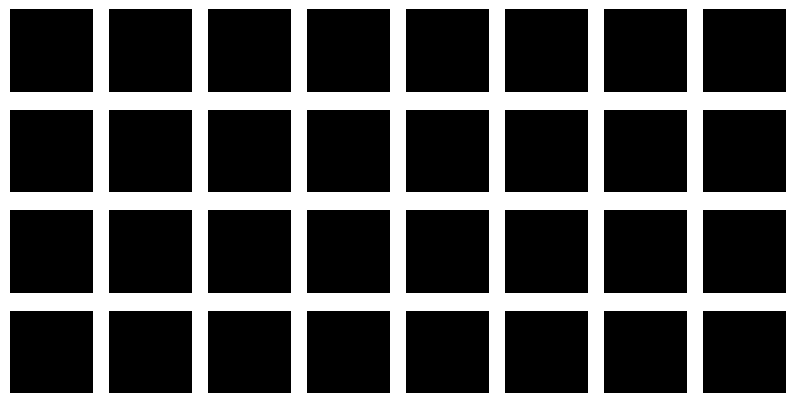

netG_14000.pt
tensor(0.5000, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5000, device='cuda:0', grad_fn=<MaxBackward1>)


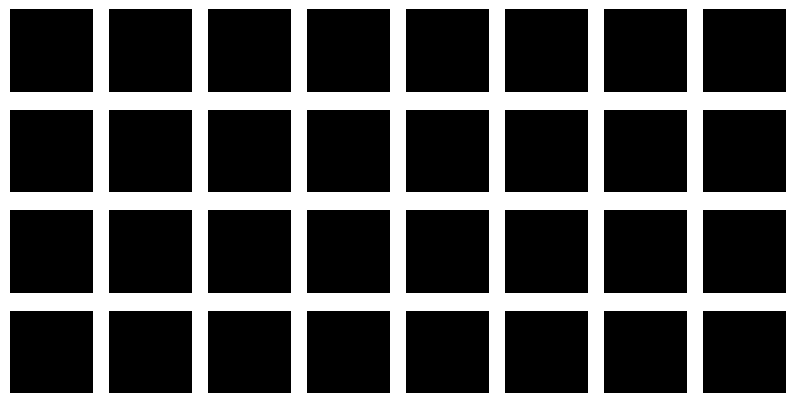

netG_16000.pt
tensor(0.5000, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5000, device='cuda:0', grad_fn=<MaxBackward1>)


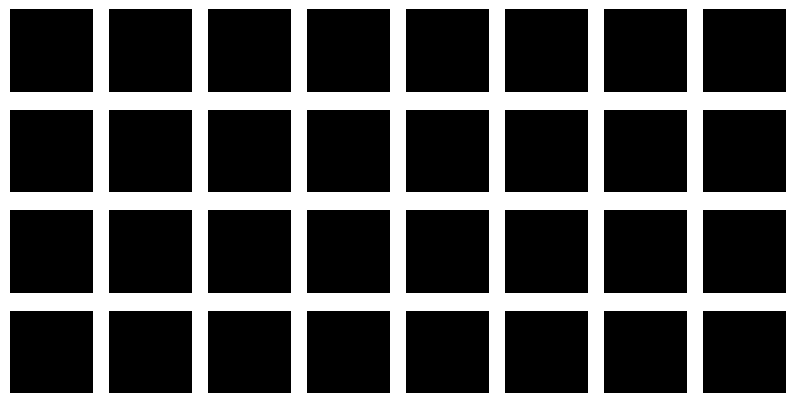

netG_18000.pt
tensor(0.5000, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5000, device='cuda:0', grad_fn=<MaxBackward1>)


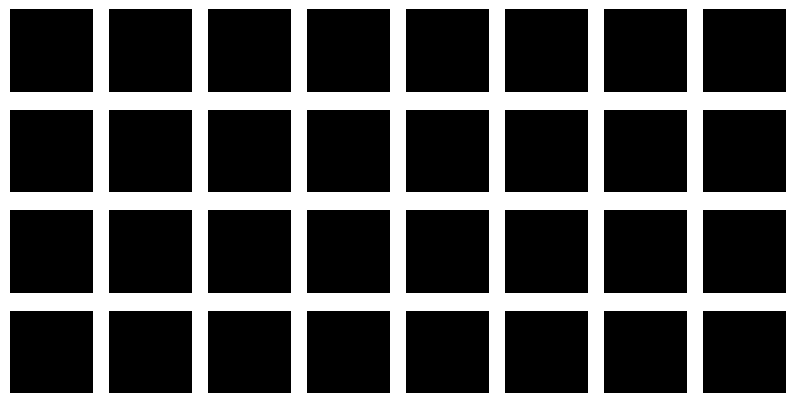

netG_20000.pt
tensor(0.5000, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5000, device='cuda:0', grad_fn=<MaxBackward1>)


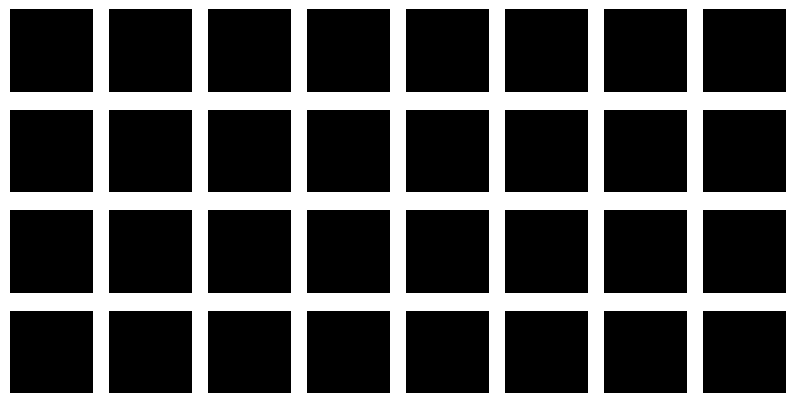

netG_22000.pt
tensor(0.5000, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5000, device='cuda:0', grad_fn=<MaxBackward1>)


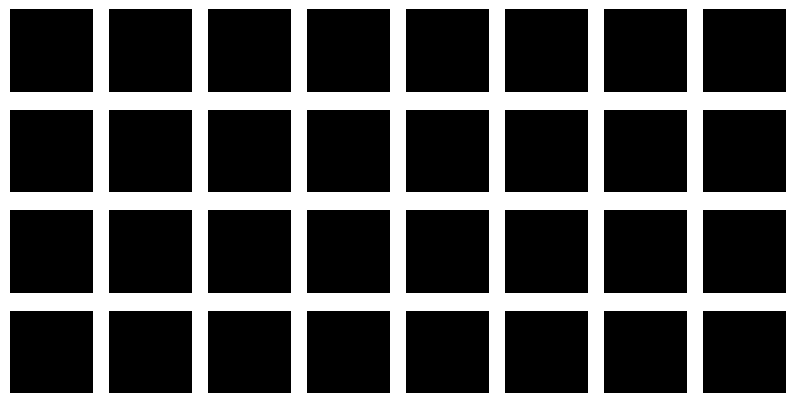

netG_24000.pt
tensor(0.5000, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5000, device='cuda:0', grad_fn=<MaxBackward1>)


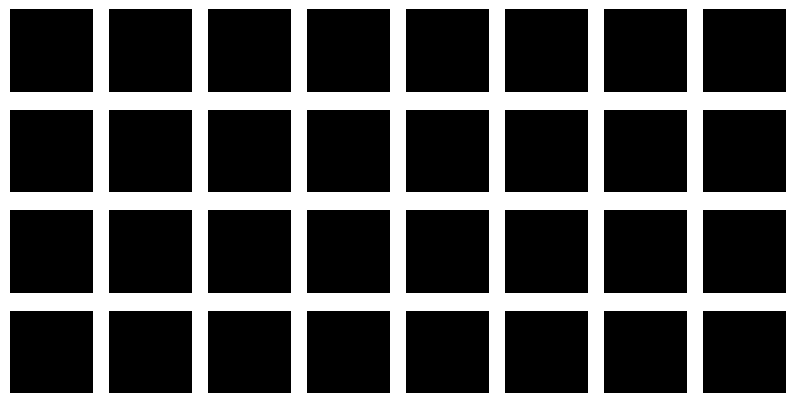

netG_26000.pt
tensor(0.5000, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5000, device='cuda:0', grad_fn=<MaxBackward1>)


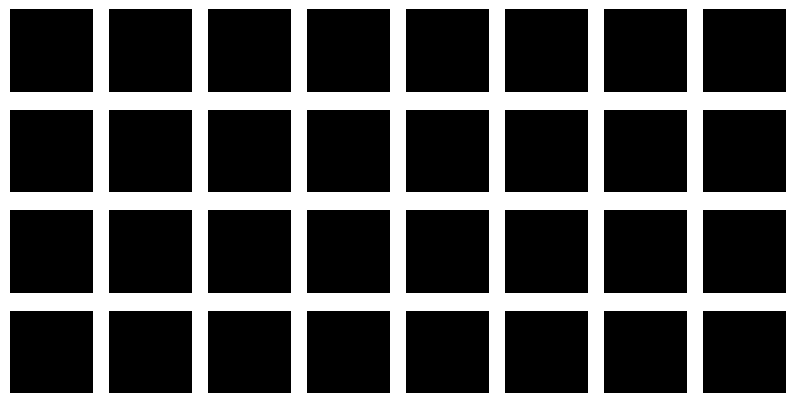

netG_28000.pt
tensor(0.5000, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5000, device='cuda:0', grad_fn=<MaxBackward1>)


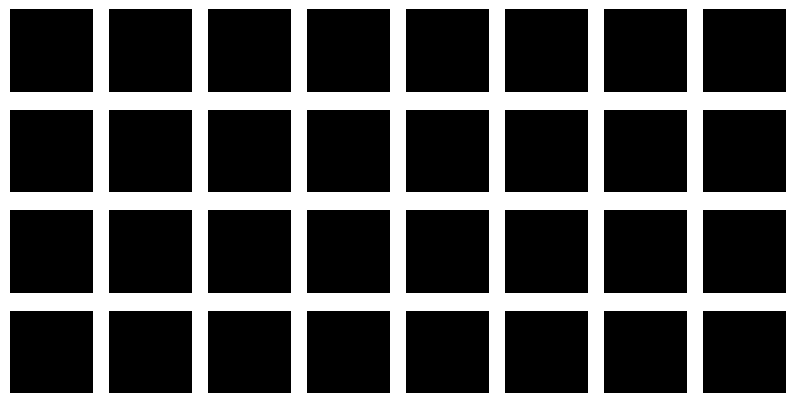

netG_30000.pt
tensor(0.5000, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5000, device='cuda:0', grad_fn=<MaxBackward1>)


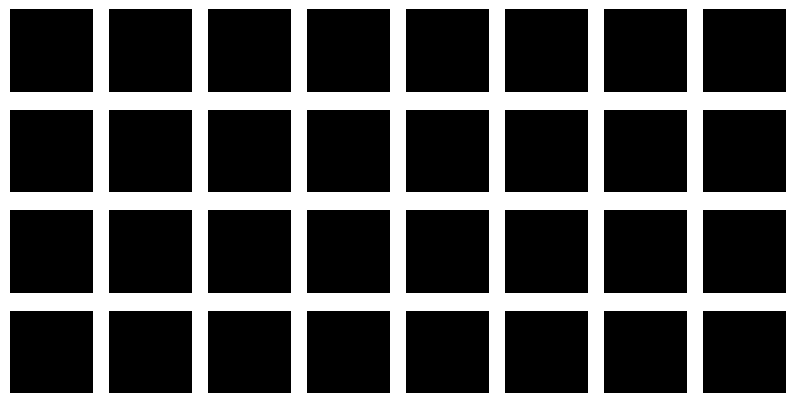

netG_32000.pt
tensor(0.5000, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5000, device='cuda:0', grad_fn=<MaxBackward1>)


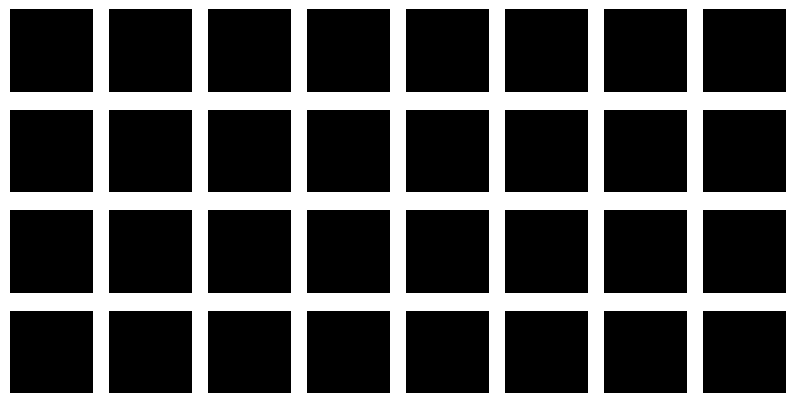

netG_34000.pt
tensor(0.5000, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5000, device='cuda:0', grad_fn=<MaxBackward1>)


KeyboardInterrupt: 

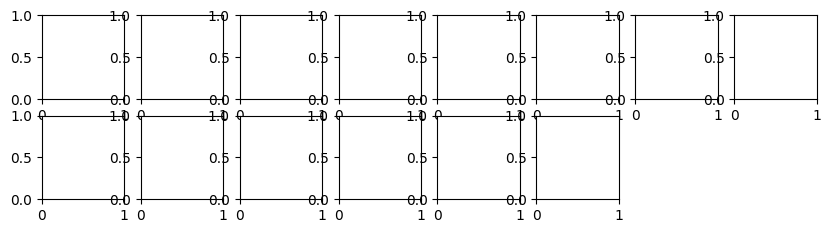

In [5]:
# Load the generator
# run_id = "/home/jason/p2/runs/private_16-12_100_32_1_inf_1e-06_0.0_0.01_0.0001_0.5_64_5_200000_LeakyReLU" # decent
run_id = "/home/jason/p2/runs/private_16-12_100_32_1_inf_1e-06_0.4_0.005_0.0001_0.5_64_4_500000_LeakyReLU" # better
run_id = "/home/jason/p2/runs/16-12_100_32_1_38.0_1e-06_0.05_0.01_0.0001_0.5_64_5_200000_LeakyReLU" # somewhat reasonable noised
run_id = "/home/jason/p2/runs/public_16-12-4_100_32_1_inf_1e-06_0.0_0.01_5e-05_0.0_64_5_300000_LeakyReLU_10.0"

run_id = run_id.split("/")[-1]
run_fp = os.path.join('runs/', run_id)

for i in range(0, 300000 + 1, 2000):
    fp = 'netG_{}.pt'.format(i)
    if os.path.exists(os.path.join(run_fp, fp)):
        print(fp)
        generate_samples(fp)

In [ ]:
# Load Discriminator_FC
run_id = "/home/jason/p2/runs/private_16-12_100_32_1_inf_1e-06_0.4_0.005_0.0001_0.5_64_4_500000_LeakyReLU" # better
run_id = run_id.split("/")[-1]
run_fp = os.path.join('runs/', run_id)

from models import Discriminator_MNIST
D = Discriminator_MNIST(nc=args.nc, ndf=args.ngf).to(device)
D.load_state_dict(torch.load(os.path.join(run_fp, 'netD_500000.pt')))

In [ ]:
# Generate 2048 fake images
noise = torch.randn(2048, 100, 1, 1).to(device)
fake = G(noise)
fake = fake.view(fake.size(0), 1, 28, 28)

In [ ]:
# Calculate Inception Score
IS = get_IS(fake)
print("Inception Score:", IS)

In [ ]:
# Calculate Frechet Inception Distance
FID = get_FID(fake)
print("Frechet Inception Distance:", FID)